In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_DATA = 'drive/MyDrive/CM_Project/Data/Matrices'

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/CM_Project/src/objectiveFunction.py .
!cp drive/MyDrive/CM_Project/src/configurations.py .
!cp drive/MyDrive/CM_Project/src/BFGS.py .
!cp drive/MyDrive/CM_Project/src/SGD.py .
!cp drive/MyDrive/CM_Project/src/exceptionHandler.py .

In [ ]:
import numpy as np
import BFGS as BFGS
import SGD as SGD
from numpy import linalg as la
import objectiveFunction as of
import time

In [ ]:
def readMatrixByFile(typeMat, indexMat):
    row = []
    pathType = ''
    if(typeMat == 1):
      pathType = 'Type1'
    elif(typeMat == 2):
      pathType = 'Type2'
    elif(typeMat == 3):
      pathType = 'Type3'
    elif(typeMat == 4):
      pathType = 'Type4'
    elif(typeMat == 6):
      pathType = 'Type6'
    elif(typeMat == 7):
      pathType = 'Type7'
    elif(typeMat == 5):
      pathType = 'Type5'

      f = open(PATH_DATA + '/' + pathType + '/hilbert.txt', 'r')
      for line in f:
        row.append(line.split())
      A = np.array(row, dtype=float)
      return A

    f = open(PATH_DATA + '/' + pathType + '/' + str(typeMat) + '_' + str(indexMat) + '.txt', 'r')
    for line in f:
        row.append(line.split())
    A = np.array(row, dtype=float)
    return A

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import seaborn as sns

# Function to plot relative errors and gradient norms
def printPlot(rel_errorsSGD, normsSGD, rel_errorsBFGS, normsBFGS, density):
    
    xLabel = 'Iterations'
    yLabel_1 = 'Relative Error'
    yLabel_2 = 'Norm Gradient'

    # Create a figure with subplots
    fig = plt.figure()
    relErr_plot = fig.add_subplot(2, 2, 1)  # Subplot for relative errors
    grad_plot = fig.add_subplot(2, 2, 2)     # Subplot for gradient norms

    fig.set_size_inches(18.5, 10.5)

    # Get the shape of matrix A
    m, n = np.shape(A)

    # Ensure that relative errors are not too small to avoid numerical issues
    for i in range(len(rel_errorsBFGS)):
        rel_errorsBFGS[i] = [max(err, 1e-16) for err in rel_errorsBFGS[i]]

    for i in range(len(rel_errorsSGD)):
        rel_errorsSGD[i] = [max(err, 1e-16) for err in rel_errorsSGD[i]]

    # Calculate average relative errors for SGD and BFGS
    avg_rel_errorsSGD = meanList(rel_errorsSGD.copy())
    avg_rel_errorsBFGS = meanList(rel_errorsBFGS.copy())

    # Print the final relative errors
    print("Rel errors SGD: " + str(avg_rel_errorsSGD[len(avg_rel_errorsSGD) - 1]))
    print("Rel errors BFGS: " + str(avg_rel_errorsBFGS[len(avg_rel_errorsBFGS) - 1]))

    # Set the y-axis limits for the relative error subplot
    plt.ylim(max(np.min(avg_rel_errorsSGD), 10e-16), 10e1)
    relErr_plot.set_title(
         ' Density =  ' + str(density) + '    M = ' + str(
              m) + ' N = ' + str(n))

    # Set the y-axis to log scale for better visualization
    relErr_plot.set_yscale('log')
    relErr_plot.set(ylabel=yLabel_1)
    relErr_plot.set(xlabel=xLabel)

    # Plot average relative errors for SGD and BFGS
    relErr_plot.plot(avg_rel_errorsSGD, label="Mean Relative Error SGD")
    relErr_plot.plot(avg_rel_errorsBFGS, label="Mean Relative Error BFGS")
    relErr_plot.legend(loc='best')

    # Calculate average gradient norms for SGD and BFGS
    avg_gradient_SGD = meanList(normsSGD.copy())
    avg_gradient_BFGS = meanList(normsBFGS.copy())

    # Set the y-axis limits for the gradient norm subplot
    grad_plot.set(ylabel=yLabel_2)
    grad_plot.set(xlabel=xLabel)
    grad_plot.set_yscale('log')

    # Calculate the minimum gradients for SGD
    min_gradients = []
    for i in range(len(normsSGD)):
        min_gradients.insert(0, normsSGD[i][len(normsSGD[i]) - 1])

    
    min_gradients = np.array(min_gradients, dtype=object)
    plt.ylim(max(np.min(min_gradients) * 10e-2, 10e-8), 10e5)

    # Plot average gradient norms for SGD and BFGS
    grad_plot.plot(avg_gradient_SGD, label="Mean Gradient SGD")
    grad_plot.plot(avg_gradient_BFGS, label="Mean Gradient BFGS")

    # Display legends and show the plot
    grad_plot.legend(loc='best')
    plt.show()


In [ ]:
# Function to calculate the mean of a list of lists, handling size mismatches
def meanList(list_to_mean):
    # Find the maximum length among the sublists
    max_len = len(max(list_to_mean, key=len))

    # Fill shorter sublists with the last element to match the maximum length
    for i in range(len(list_to_mean)):
        if len(list_to_mean[i]) < max_len:
            # Create a temporary array with the last element repeated to match the length
            temp = np.full((max_len - (len(list_to_mean[i]) - 1) - 1, 1), list_to_mean[i][len(list_to_mean[i]) - 1])
            # Concatenate the temporary array to the sublist
            list_to_mean[i] = np.array(np.concatenate((list_to_mean[i], temp), axis=None))

    # Convert the list of lists to a NumPy array for efficient calculations
    list_to_mean = np.array(list_to_mean)

    # Calculate the geometric mean along axis 0 (columns)
    return np.prod(list_to_mean, axis=0) ** (1.0 / len(list_to_mean))

## Experiments on different matrices with ε = 1e-6
Here, we will test the SGD and BFGS algorithms on different random matrices using a stopping criteria for norm of the gradient equal to **1e-6**. In detail:
- 5 matrices with 1500 × 500 and density = 1
- 5 matrices with 1500 × 50 and density = 1
- 5 matrices with 1000 × 250 and density = 1
- 5 matrices with 1000 × 250 and density = 0.1
- 5 matrices with 1000 × 100 and density = 0.1
- 5 matrices with 1000 × 25 and density = 0.1

In addition, we will plot the relative errors and gradient norms. We will calculate the elapsed time for running.

Status SDG: stopped, maxIter - Result SGD: 11847603.00885633 Status BFGS: optimal - Result BFGS: 11847603.014277006 - Result norm: 11847603.014276998
Status SDG: optimal - Result SGD: 4469987.894671969 Status BFGS: optimal - Result BFGS: 4469987.894671969 - Result norm: 4469987.894671966
Status SDG: stopped, maxIter - Result SGD: 317817.5948031895 Status BFGS: optimal - Result BFGS: 317817.5948031896 - Result norm: 317817.5948031897
Status SDG: stopped, maxIter - Result SGD: 17671335.994965233 Status BFGS: error rho - Result BFGS: 17671335.995079044 - Result norm: 17671335.99507904
Status SDG: stopped, maxIter - Result SGD: 10244858.2226646 Status BFGS: optimal - Result BFGS: 10244858.22395924 - Result norm: 10244858.223959252
Mean SGD time: 0.2531548023223877- Mean BFGS time: 2.058928203582764 - Mean norm time: 0.1122664451599121
Rel errors SGD: 6.627686747124647e-13
Rel errors BFGS: 4.541276701596724e-16


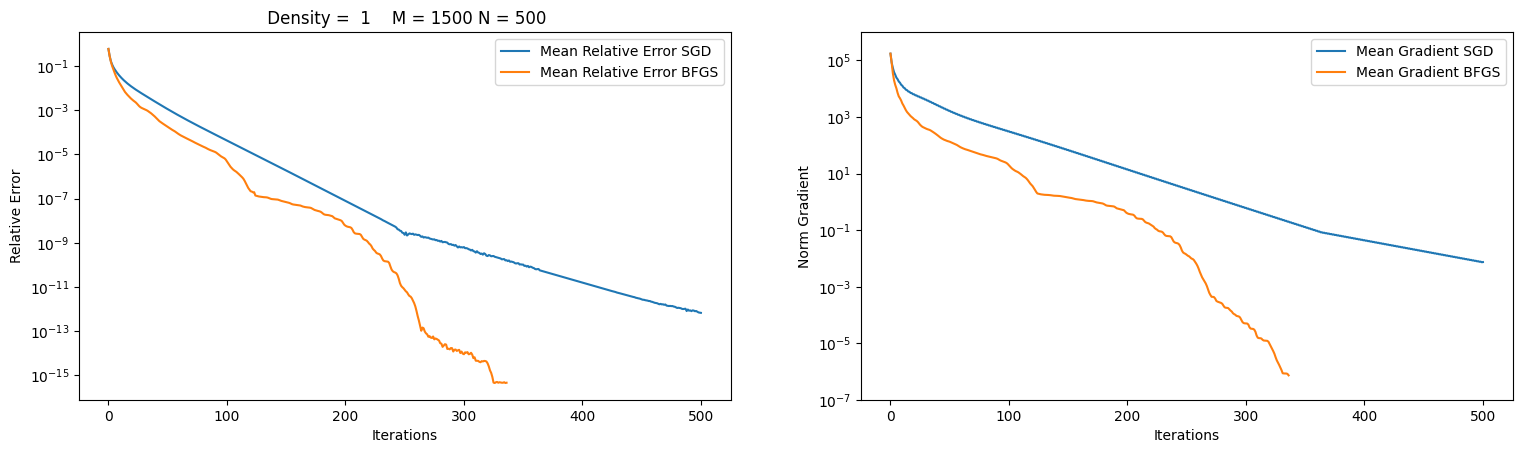

Status SDG: optimal - Result SGD: 26803.66303946455 Status BFGS: optimal - Result BFGS: 26803.66303946455 - Result norm: 26803.663039464518
Status SDG: stopped, maxIter - Result SGD: 8645518.14737587 Status BFGS: optimal - Result BFGS: 8645518.147624923 - Result norm: 8645518.14762492
Status SDG: stopped, maxIter - Result SGD: 5717180.911420279 Status BFGS: error rho - Result BFGS: 5717180.91142028 - Result norm: 5717180.911420279
Status SDG: optimal - Result SGD: 124914.77473486695 Status BFGS: optimal - Result BFGS: 124914.77473486688 - Result norm: 124914.77473486717
Status SDG: optimal - Result SGD: 1374377.717168164 Status BFGS: optimal - Result BFGS: 1374377.7171681635 - Result norm: 1374377.7171681616
Mean SGD time: 0.10961942672729492- Mean BFGS time: 0.3027338981628418 - Mean norm time: 0.019455814361572267
Rel errors SGD: 6.361311777629673e-15
Rel errors BFGS: 7.700363654433752e-16


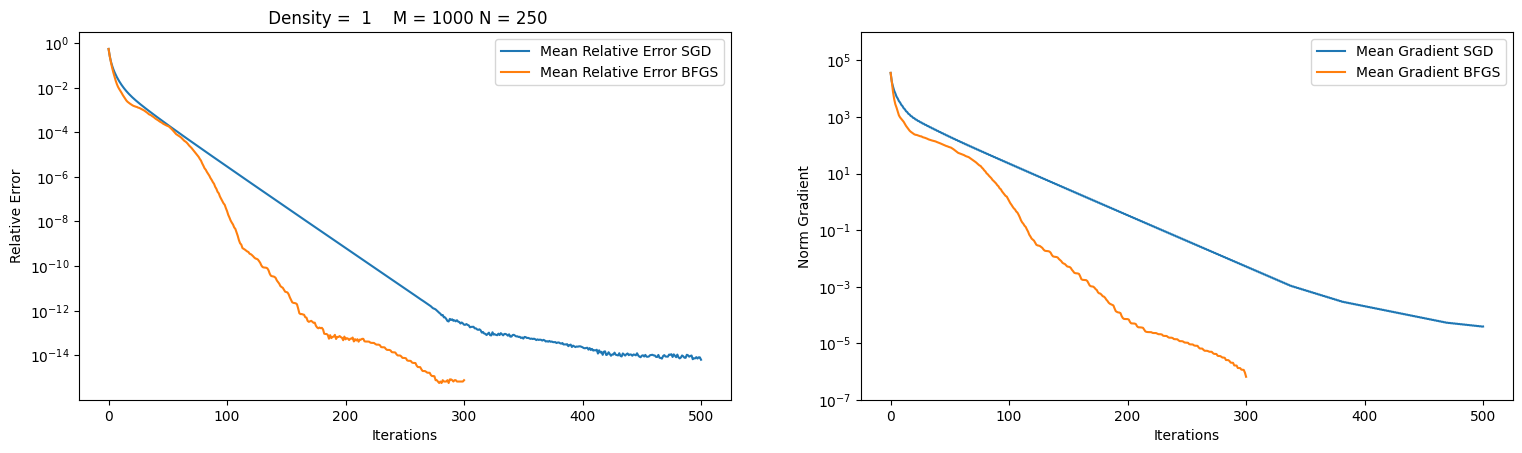

Status SDG: stopped, maxIter - Result SGD: 951771.258765794 Status BFGS: optimal - Result BFGS: 951771.2587657939 - Result norm: 951771.2587657955
Status SDG: optimal - Result SGD: 597703.8277965016 Status BFGS: optimal - Result BFGS: 597703.8277965016 - Result norm: 597703.8277965013
Status SDG: stopped, maxIter - Result SGD: 408782.74704629136 Status BFGS: optimal - Result BFGS: 408782.7470465229 - Result norm: 408782.74704652245
Status SDG: optimal - Result SGD: 809836.563282261 Status BFGS: optimal - Result BFGS: 809836.5632822613 - Result norm: 809836.5632822606
Status SDG: optimal - Result SGD: 189955.91715398317 Status BFGS: optimal - Result BFGS: 189955.91715398314 - Result norm: 189955.9171539833
Mean SGD time: 0.20181879997253419- Mean BFGS time: 0.6089267730712891 - Mean norm time: 0.029615306854248048
Rel errors SGD: 2.6197306155826846e-15
Rel errors BFGS: 8.712719303610068e-16


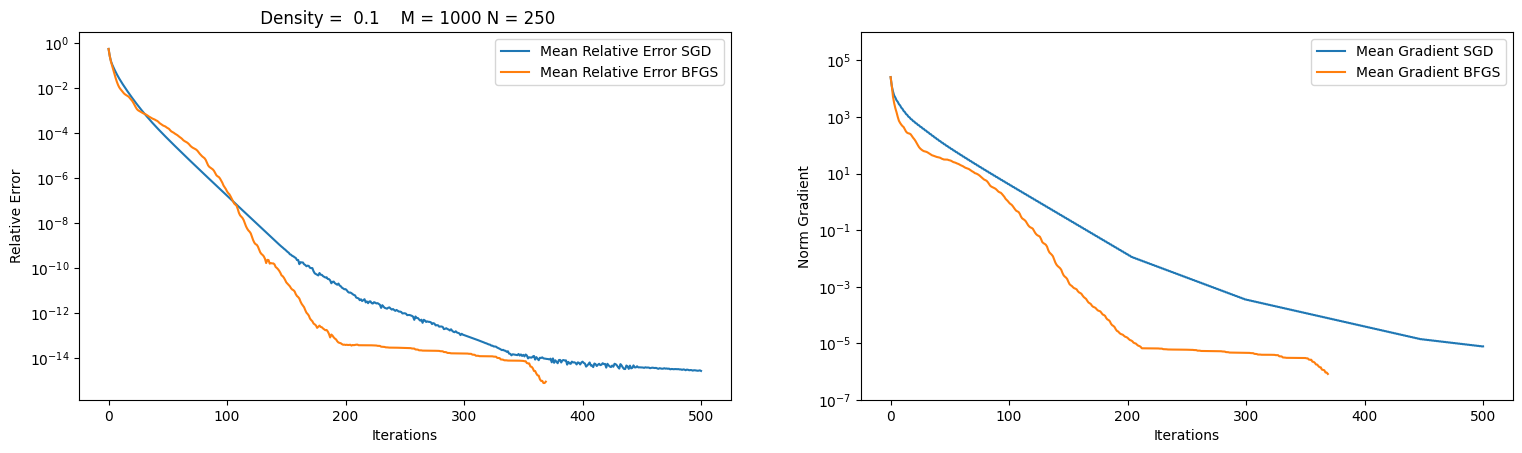

Status SDG: stopped, maxIter - Result SGD: 342913.1713713865 Status BFGS: optimal - Result BFGS: 342913.17137138644 - Result norm: 342913.1713713864
Status SDG: optimal - Result SGD: 222458.0466865977 Status BFGS: optimal - Result BFGS: 222458.04668659778 - Result norm: 222458.04668659766
Status SDG: optimal - Result SGD: 6785.6129089013375 Status BFGS: optimal - Result BFGS: 6785.612908901335 - Result norm: 6785.612908901331
Status SDG: optimal - Result SGD: 271401.12965196825 Status BFGS: optimal - Result BFGS: 271401.12965196825 - Result norm: 271401.1296519685
Status SDG: stopped, maxIter - Result SGD: 778412.7343728039 Status BFGS: optimal - Result BFGS: 778412.734379003 - Result norm: 778412.7343790025
Mean SGD time: 0.07164654731750489- Mean BFGS time: 0.05373272895812988 - Mean norm time: 0.004779958724975586
Rel errors SGD: 3.0964846692635823e-15
Rel errors BFGS: 4.977434551057371e-16


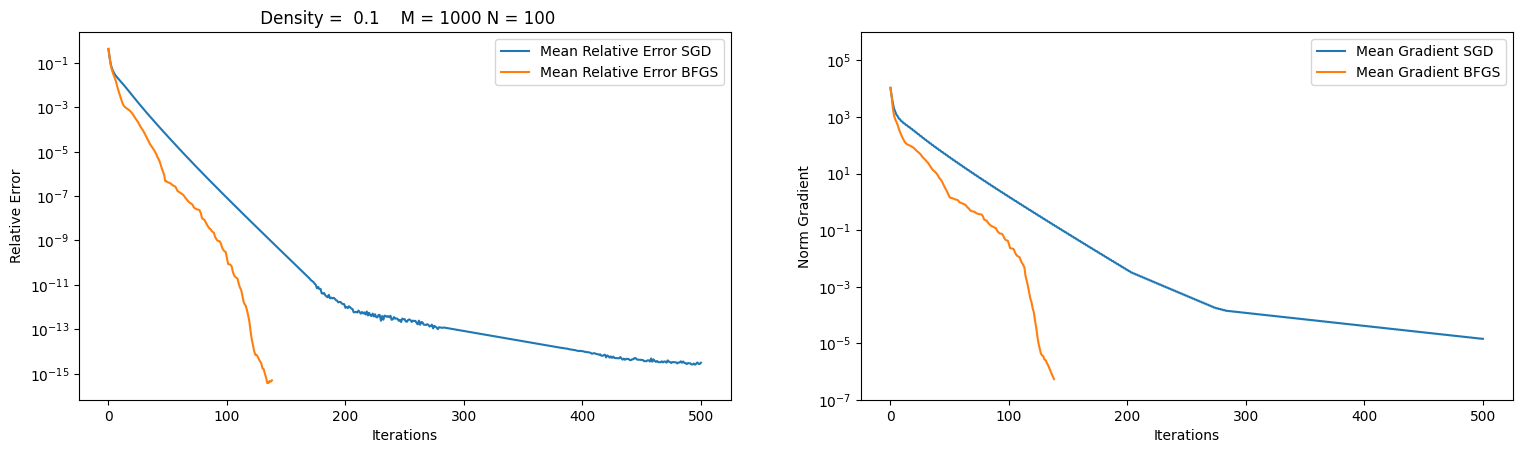

Status SDG: optimal - Result SGD: 746230.3044851939 Status BFGS: optimal - Result BFGS: 746230.3044851939 - Result norm: 746230.3044851936
Status SDG: optimal - Result SGD: 279084.5831146639 Status BFGS: optimal - Result BFGS: 279084.58311466395 - Result norm: 279084.58311466384
Status SDG: optimal - Result SGD: 255871.5668981186 Status BFGS: optimal - Result BFGS: 255871.56689811862 - Result norm: 255871.56689811853
Status SDG: optimal - Result SGD: 452783.1889400805 Status BFGS: optimal - Result BFGS: 452783.18894008046 - Result norm: 452783.18894008064
Status SDG: optimal - Result SGD: 249434.1593277391 Status BFGS: optimal - Result BFGS: 249434.15932773906 - Result norm: 249434.159327739
Mean SGD time: 0.023387622833251954- Mean BFGS time: 0.009271955490112305 - Mean norm time: 0.000933980941772461
Rel errors SGD: 2.8849563898991706e-16
Rel errors BFGS: 3.593879434338885e-16


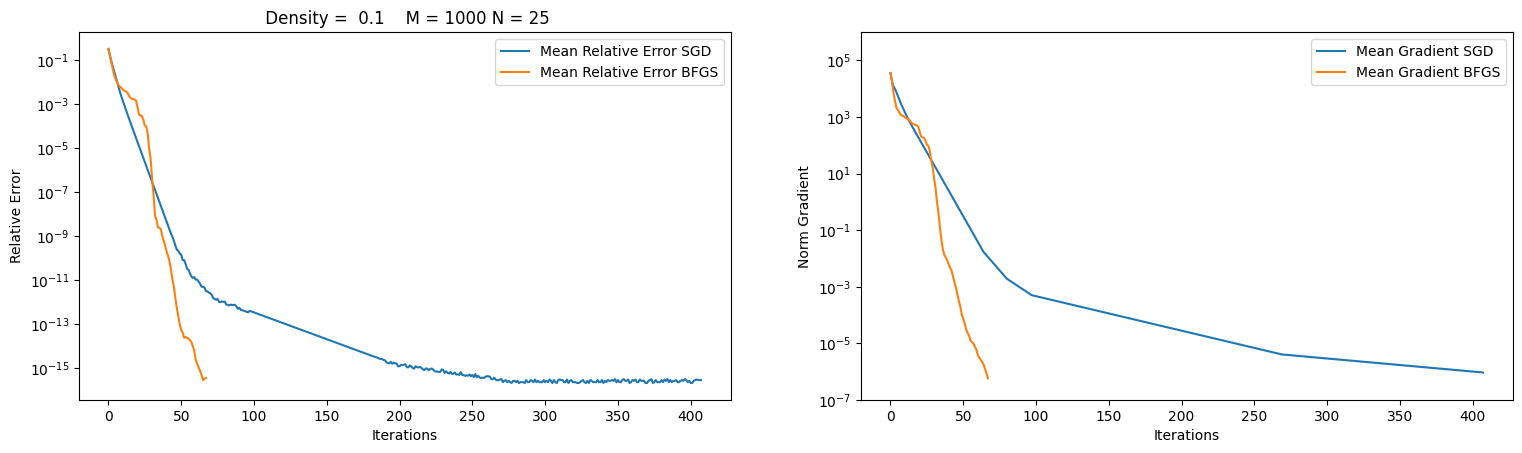

Status SDG: optimal - Result SGD: 10316834.333882106 Status BFGS: optimal - Result BFGS: 10316834.333882106 - Result norm: 10316834.333882108
Status SDG: optimal - Result SGD: 6469932.388127152 Status BFGS: optimal - Result BFGS: 6469932.388127152 - Result norm: 6469932.388127156
Status SDG: stopped, maxIter - Result SGD: 7476322.966274929 Status BFGS: optimal - Result BFGS: 7476322.966561061 - Result norm: 7476322.966561057
Status SDG: optimal - Result SGD: 2075698.6865939016 Status BFGS: optimal - Result BFGS: 2075698.686593902 - Result norm: 2075698.6865939032
Status SDG: stopped, maxIter - Result SGD: 5032534.8912824765 Status BFGS: optimal - Result BFGS: 5032714.4751056805 - Result norm: 5032714.475105678
Mean SGD time: 0.05603570938110351- Mean BFGS time: 0.025196266174316407 - Mean norm time: 0.004321050643920898
Rel errors SGD: 6.448086558250287e-13
Rel errors BFGS: 4.580345207790267e-16


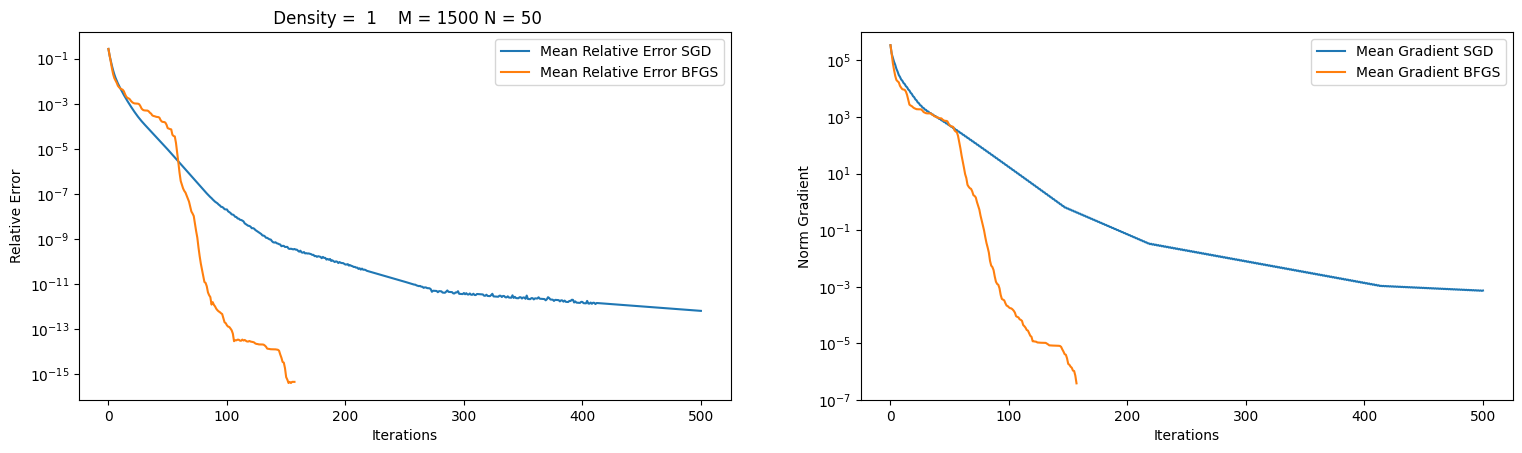

In [ ]:
# Loop over different scenarios (i values)
for i in range(1, 8):

    # Skip iteration when i is 5
    if i == 5:
        continue

    # Initialize lists for relative errors, gradients, and execution times
    rel_errors_SGD = []
    rel_errors_BFGS = []
    gradientsSGD = []
    gradientsBFGS = []
    timesBFGS = []
    timesSGD = []
    timesNorm = []

    # Read matrix A from a file based on i value
    A = readMatrixByFile(1, 1)

    # Set variables x and density based on i value
    if i == 1:
        x = np.random.rand(500, 1)
        density = 1
    elif i == 2:
        x = np.random.rand(250, 1)
        density = 1
    elif i == 3:
        x = np.random.rand(250, 1)
        density = 0.1
    elif i == 4:
        x = np.random.rand(100, 1)
        density = 0.1
    elif i == 6:
        x = np.random.rand(25, 1)
        density = 0.1
    elif i == 7:
        x = np.random.rand(50, 1)
        density = 1

    # Loop over different files (j values)
    for j in range(1, 6):
        
        A = readMatrixByFile(i, j)
        # Create an objective function instance
        f = of.objectiveFunction(A)

        # Measure the time to calculate the norm of A
        t_start = time.time()
        norm = la.norm(A, ord=2) ** 2
        t_end = time.time()
        t_tot = t_end - t_start
        timesNorm.append(t_tot)

        # BFGS optimization
        t_start_BFGS = time.time()
        optimizerBFGS = BFGS.BFGS(f, x, 1, 1e-4, norm)
        gradientBFGS, normsBFGS, status_BFGS = optimizerBFGS.applyBFGS()
        t_end_BFGS = time.time()
        t_tot = t_end_BFGS - t_start_BFGS
        timesBFGS.append(t_tot)

        # SGD optimization
        t_start_SGD = time.time()
        optimizerSGD = SGD.SGD(f, x, 1e-4, norm)
        normsSDG, gradientSDG, status_SDG = optimizerSGD.applySGD()
        t_end_SGD = time.time()
        t_tot = t_end_SGD - t_start_SGD
        timesSGD.append(t_tot)

        # Calculate relative errors for BFGS and SGD
        normsBFGS = np.array(normsBFGS)
        gradientsBFGS.insert(j - 1, gradientBFGS)
        norm_vec_BFGS = np.ones(normsBFGS.size) * norm
        rel_errors_BFGS.insert(j - 1, (abs(normsBFGS - norm_vec_BFGS) / abs(norm_vec_BFGS)))

        normsSDG = np.array(normsSDG)
        gradientsSGD.insert(j - 1, gradientSDG)
        norm_vec_SGD = np.ones(normsSDG.size) * norm
        rel_errors_SGD.insert(j - 1, (abs(normsSDG - norm_vec_SGD) / abs(norm_vec_SGD)))

        # Print optimization results for each iteration
        print("Status SDG: " + status_SDG + " - Result SGD: " + str(normsSDG[normsSDG.size - 1]) +
              " Status BFGS: " + status_BFGS + " - Result BFGS: " + str(normsBFGS[normsBFGS.size - 1]) +
              " - Result norm: " + str(norm))

    # Print mean execution times and plot the results
    print("Mean SGD time: " + str(np.mean(timesSGD)) +
          " - Mean BFGS time: " + str(np.mean(timesBFGS)) +
          " - Mean norm time: " + str(np.mean(timesNorm)))
    printPlot(rel_errors_SGD, gradientsSGD, rel_errors_BFGS, gradientsBFGS, density)


## Experiments on different matrices with ε = 1e-4
Here, we will test the SGD and BFGS algorithms on different random matrices using a stopping criteria for norm of the gradient equal to **1e-4**. In detail:
- 5 matrices with 1500 × 500 and density = 1
- 5 matrices with 1500 × 50 and density = 1
- 5 matrices with 1000 × 250 and density = 1
- 5 matrices with 1000 × 250 and density = 0.1
- 5 matrices with 1000 × 100 and density = 0.1
- 5 matrices with 1000 × 25 and density = 0.1

In addition, we will plot the relative errors and gradient norms. We will calculate the elapsed time for running.

Status SDG: stopped, maxIter - Result SGD: 11847603.014125431 Status BFGS: optimal - Result BFGS: 11847603.014277007 - Result norm: 11847603.014276998
Status SDG: optimal - Result SGD: 4469987.89467197 Status BFGS: optimal - Result BFGS: 4469987.894671969 - Result norm: 4469987.894671966
Status SDG: optimal - Result SGD: 317817.59480318933 Status BFGS: optimal - Result BFGS: 317817.5948031858 - Result norm: 317817.5948031897
Status SDG: stopped, maxIter - Result SGD: 17671335.987625245 Status BFGS: optimal - Result BFGS: 17671335.995079044 - Result norm: 17671335.99507904
Status SDG: stopped, maxIter - Result SGD: 10244858.216471775 Status BFGS: optimal - Result BFGS: 10244858.22395924 - Result norm: 10244858.223959252
Mean SGD time: 0.2300417900085449- Mean BFGS time: 2.359316873550415 - Mean norm time: 0.11285367012023925
Rel errors SGD: 1.2928374023532189e-12
Rel errors BFGS: 1.1009685864216574e-15


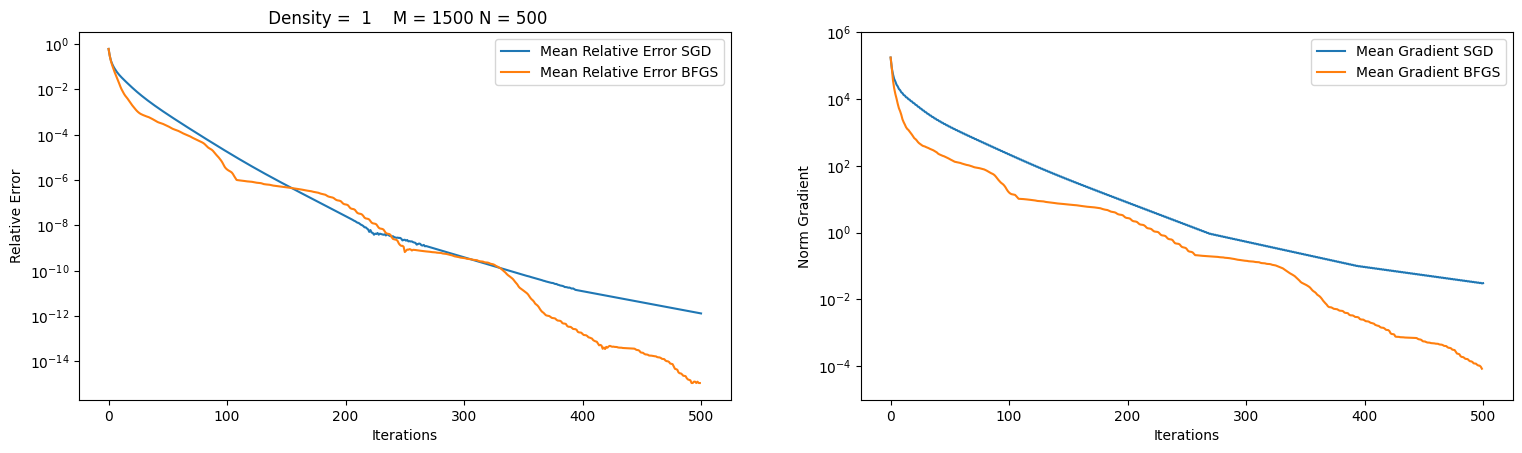

Status SDG: optimal - Result SGD: 26803.663039463885 Status BFGS: optimal - Result BFGS: 26803.663039459534 - Result norm: 26803.663039464518
Status SDG: stopped, maxIter - Result SGD: 8645518.14716057 Status BFGS: optimal - Result BFGS: 8645518.14762492 - Result norm: 8645518.14762492
Status SDG: stopped, maxIter - Result SGD: 5717180.911420282 Status BFGS: optimal - Result BFGS: 5717180.911420283 - Result norm: 5717180.911420279
Status SDG: optimal - Result SGD: 124914.77473486676 Status BFGS: optimal - Result BFGS: 124914.77473486608 - Result norm: 124914.77473486717
Status SDG: optimal - Result SGD: 1374377.7171681628 Status BFGS: optimal - Result BFGS: 1374377.7171681633 - Result norm: 1374377.7171681616
Mean SGD time: 0.20300717353820802- Mean BFGS time: 0.5606201648712158 - Mean norm time: 0.03618202209472656
Rel errors SGD: 1.764962602840973e-14
Rel errors BFGS: 2.6287718197493284e-15


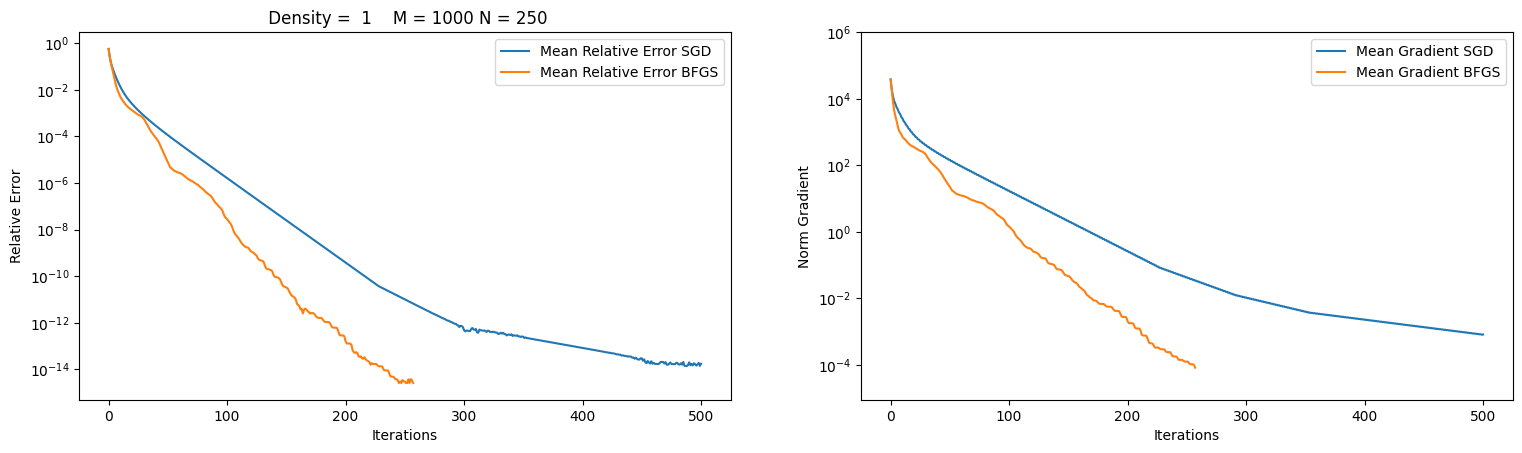

Status SDG: optimal - Result SGD: 951771.2587657938 Status BFGS: optimal - Result BFGS: 951771.2587657935 - Result norm: 951771.2587657955
Status SDG: optimal - Result SGD: 597703.8277965015 Status BFGS: optimal - Result BFGS: 597703.8277964706 - Result norm: 597703.8277965013
Status SDG: stopped, maxIter - Result SGD: 408782.7470416551 Status BFGS: optimal - Result BFGS: 408782.74704652274 - Result norm: 408782.74704652245
Status SDG: optimal - Result SGD: 809836.5632822609 Status BFGS: optimal - Result BFGS: 809836.5632822611 - Result norm: 809836.5632822606
Status SDG: optimal - Result SGD: 189955.9171539832 Status BFGS: optimal - Result BFGS: 189955.9171539825 - Result norm: 189955.9171539833
Mean SGD time: 0.07781352996826171- Mean BFGS time: 0.2431149959564209 - Mean norm time: 0.02015833854675293
Rel errors SGD: 3.8477660144084684e-15
Rel errors BFGS: 2.9576800520562353e-15


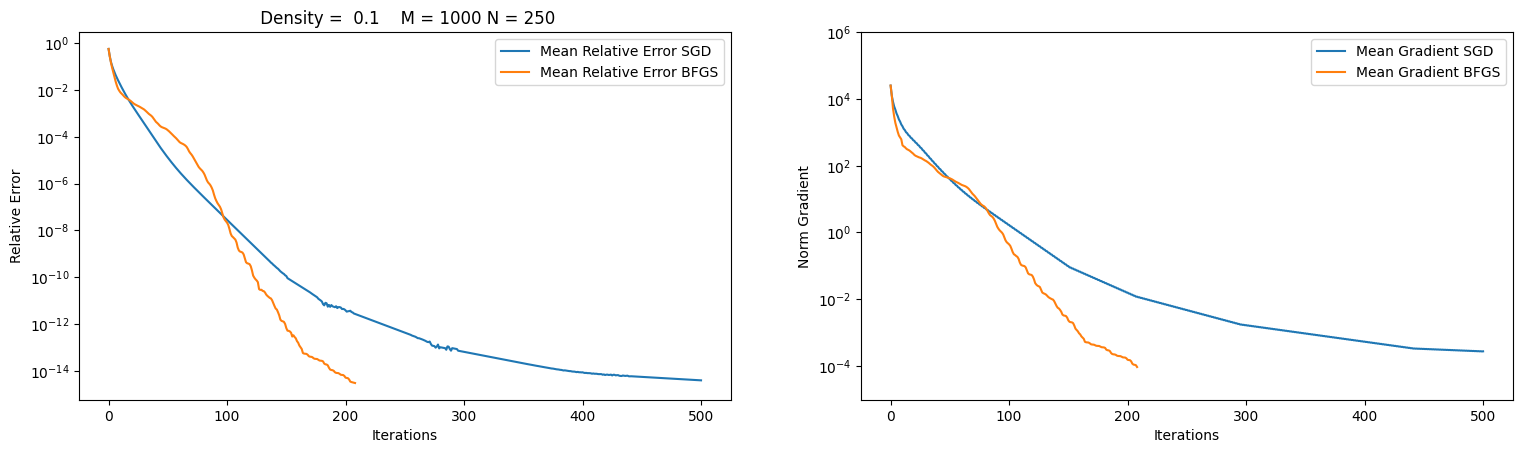

Status SDG: stopped, maxIter - Result SGD: 342913.1713713862 Status BFGS: optimal - Result BFGS: 342913.17137138627 - Result norm: 342913.1713713864
Status SDG: optimal - Result SGD: 222458.04668659763 Status BFGS: optimal - Result BFGS: 222458.04668659766 - Result norm: 222458.04668659766
Status SDG: optimal - Result SGD: 6785.61290890038 Status BFGS: optimal - Result BFGS: 6785.612908490781 - Result norm: 6785.612908901331
Status SDG: optimal - Result SGD: 271401.1296519683 Status BFGS: optimal - Result BFGS: 271401.12965191965 - Result norm: 271401.1296519685
Status SDG: stopped, maxIter - Result SGD: 778412.7342728778 Status BFGS: optimal - Result BFGS: 778412.7343790033 - Result norm: 778412.7343790025
Mean SGD time: 0.066109037399292- Mean BFGS time: 0.07594876289367676 - Mean norm time: 0.004559707641601562
Rel errors SGD: 1.52297104209032e-14
Rel errors BFGS: 1.3107698050029415e-14


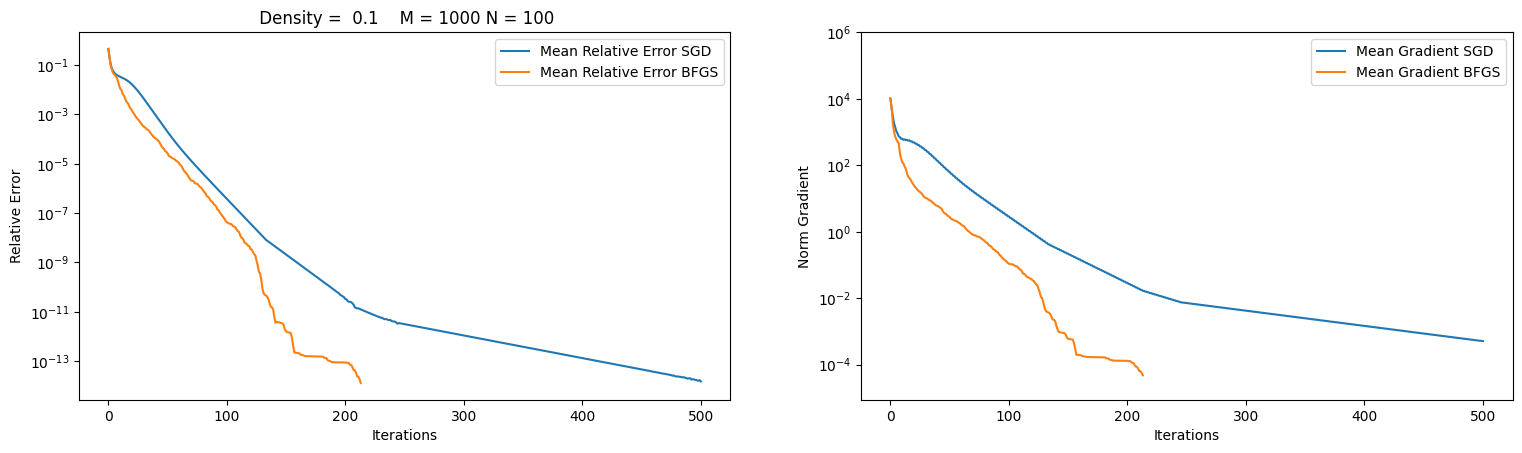

Status SDG: optimal - Result SGD: 746230.3044851938 Status BFGS: optimal - Result BFGS: 746230.3044851939 - Result norm: 746230.3044851936
Status SDG: optimal - Result SGD: 279084.58311466395 Status BFGS: optimal - Result BFGS: 279084.5831146639 - Result norm: 279084.58311466384
Status SDG: optimal - Result SGD: 255871.56689811856 Status BFGS: optimal - Result BFGS: 255871.5668981186 - Result norm: 255871.56689811853
Status SDG: optimal - Result SGD: 452783.18894008064 Status BFGS: optimal - Result BFGS: 452783.1889400805 - Result norm: 452783.18894008064
Status SDG: optimal - Result SGD: 249434.1593277389 Status BFGS: optimal - Result BFGS: 249434.1593277391 - Result norm: 249434.159327739
Mean SGD time: 0.026224231719970702- Mean BFGS time: 0.009732532501220702 - Mean norm time: 0.0006806373596191407
Rel errors SGD: 2.332839059565619e-16
Rel errors BFGS: 2.8849563898991706e-16


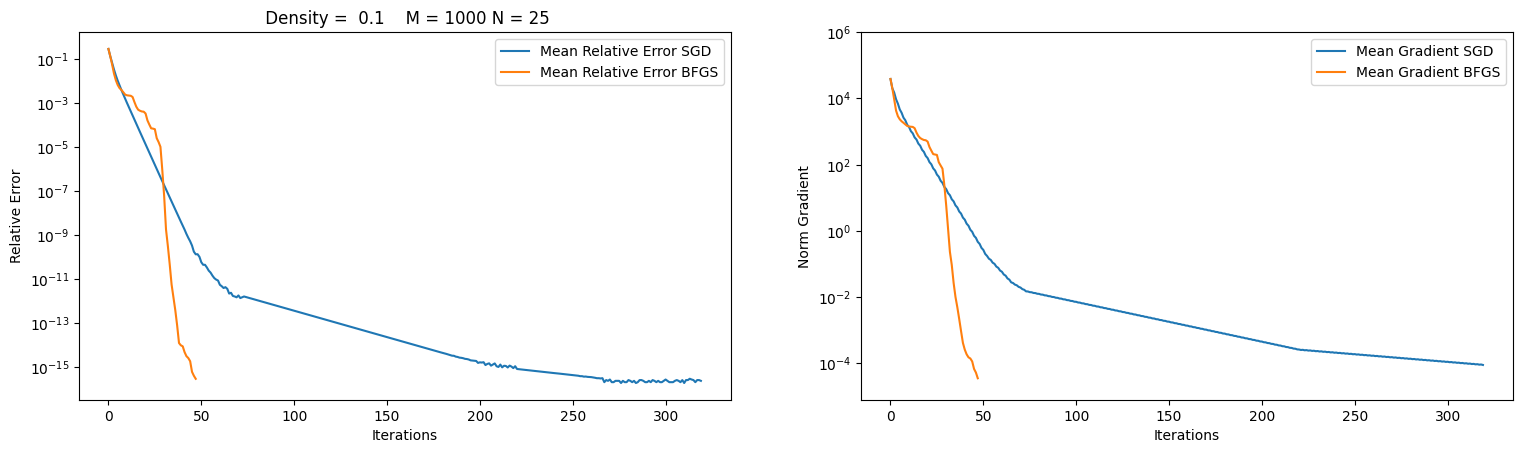

Status SDG: optimal - Result SGD: 10316834.333882108 Status BFGS: optimal - Result BFGS: 10316834.33388211 - Result norm: 10316834.333882108
Status SDG: optimal - Result SGD: 6469932.388127153 Status BFGS: error min step - Result BFGS: 6316194.546717283 - Result norm: 6469932.388127156
Status SDG: stopped, maxIter - Result SGD: 7476322.966439084 Status BFGS: optimal - Result BFGS: 7476322.96656106 - Result norm: 7476322.966561057
Status SDG: optimal - Result SGD: 2075698.686593902 Status BFGS: optimal - Result BFGS: 2075698.6865939011 - Result norm: 2075698.6865939032
Status SDG: stopped, maxIter - Result SGD: 5030264.389295579 Status BFGS: error min step - Result BFGS: 5012749.016714964 - Result norm: 5032714.475105678
Mean SGD time: 0.059669208526611325- Mean BFGS time: 0.016405582427978516 - Mean norm time: 0.0020592212677001953
Rel errors SGD: 7.191576204502974e-13
Rel errors BFGS: 9.694076015775047e-11


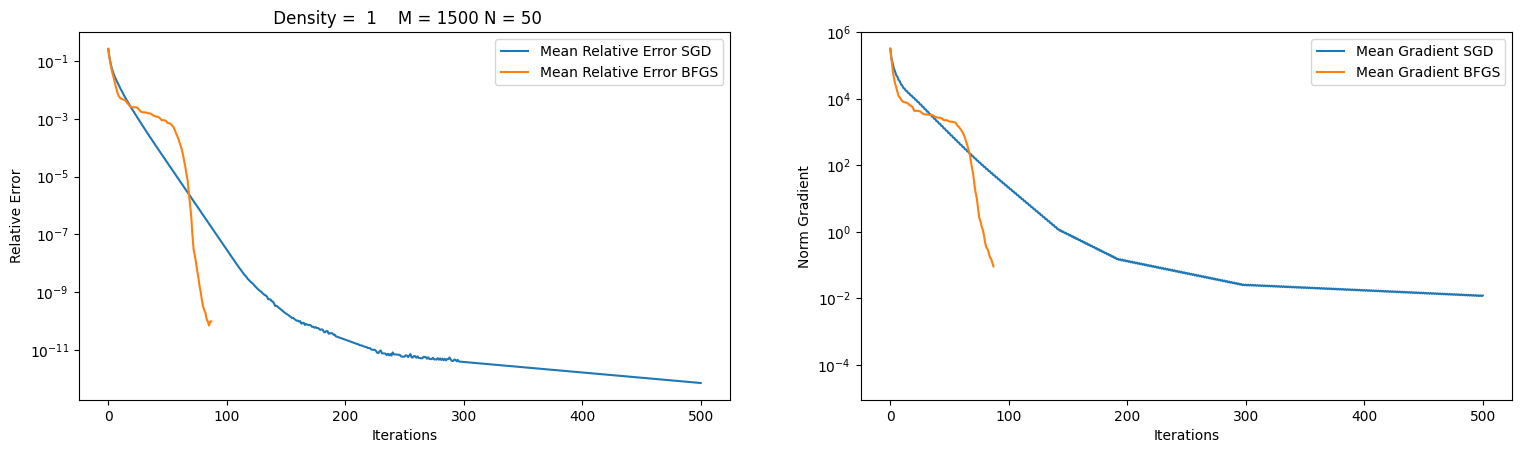

In [ ]:
# Loop over different scenarios (i values)
for i in range(1, 8):

    # Skip iteration when i is 5
    if i == 5:
        continue

    # Initialize lists for relative errors, gradients, and execution times
    rel_errors_SGD = []
    rel_errors_BFGS = []
    gradientsSGD = []
    gradientsBFGS = []
    timesBFGS = []
    timesSGD = []
    timesNorm = []

    # Read matrix A from a file based on i value
    A = readMatrixByFile(1, 1)

    # Set variables x and density based on i value
    if i == 1:
        x = np.random.rand(500, 1)
        density = 1
    elif i == 2:
        x = np.random.rand(250, 1)
        density = 1
    elif i == 3:
        x = np.random.rand(250, 1)
        density = 0.1
    elif i == 4:
        x = np.random.rand(100, 1)
        density = 0.1
    elif i == 6:
        x = np.random.rand(25, 1)
        density = 0.1
    elif i == 7:
        x = np.random.rand(50, 1)
        density = 1

    # Loop over different files (j values)
    for j in range(1, 6):
        # Read matrix A from a file based on i and j values
        A = readMatrixByFile(i, j)
        # Create an objective function instance
        f = of.objectiveFunction(A)

        # Measure the time to calculate the norm of A
        t_start = time.time()
        norm = la.norm(A, ord=2) ** 2
        t_end = time.time()
        t_tot = t_end - t_start
        timesNorm.append(t_tot)

        # BFGS optimization
        t_start_BFGS = time.time()
        optimizerBFGS = BFGS.BFGS(f, x, 1, 1e-4, norm)
        gradientBFGS, normsBFGS, status_BFGS = optimizerBFGS.applyBFGS()
        t_end_BFGS = time.time()
        t_tot = t_end_BFGS - t_start_BFGS
        timesBFGS.append(t_tot)

        # SGD optimization
        t_start_SGD = time.time()
        optimizerSGD = SGD.SGD(f, x, 1e-4, norm)
        normsSDG, gradientSDG, status_SDG = optimizerSGD.applySGD()
        t_end_SGD = time.time()
        t_tot = t_end_SGD - t_start_SGD
        timesSGD.append(t_tot)

        # Calculate relative errors for BFGS and SGD
        normsBFGS = np.array(normsBFGS)
        gradientsBFGS.insert(j - 1, gradientBFGS)
        norm_vec_BFGS = np.ones(normsBFGS.size) * norm
        rel_errors_BFGS.insert(j - 1, (abs(normsBFGS - norm_vec_BFGS) / abs(norm_vec_BFGS)))

        normsSDG = np.array(normsSDG)
        gradientsSGD.insert(j - 1, gradientSDG)
        norm_vec_SGD = np.ones(normsSDG.size) * norm
        rel_errors_SGD.insert(j - 1, (abs(normsSDG - norm_vec_SGD) / abs(norm_vec_SGD)))

        # Print optimization results for each iteration
        print("Status SDG: " + status_SDG + " - Result SGD: " + str(normsSDG[normsSDG.size - 1]) +
              " Status BFGS: " + status_BFGS + " - Result BFGS: " + str(normsBFGS[normsBFGS.size - 1]) +
              " - Result norm: " + str(norm))

    # Print mean execution times and plot the results
    print("Mean SGD time: " + str(np.mean(timesSGD)) +
          " - Mean BFGS time: " + str(np.mean(timesBFGS)) +
          " - Mean norm time: " + str(np.mean(timesNorm)))
    printPlot(rel_errors_SGD, gradientsSGD, rel_errors_BFGS, gradientsBFGS, density)


## Experiment on badly ill-conditioned matrix
In this part, we will test the SGD and BFGS algorithms on a Hilbert matrix with 1000 × 1000 to test the performance and the time to run the algorithm.

In [ ]:
A = readMatrixByFile(5,1)
f = of.objectiveFunction(A)
# Generate a random initial vector x for optimization
x = np.random.rand(1000, 1)

# Initialize lists for relative errors, gradients, and execution times
rel_errors_SGD = []
rel_errors_BFGS = []
gradientsSGD = []
gradientsBFGS = []

# Measure the time to perform the BFGS
t_start_BFGS = time.time()
optimizerBFGS = BFGS.BFGS(f, x)
gradientBFGS, normsBFGS, status = optimizerBFGS.applyBFGS()
t_end_BFGS = time.time()
t_tot = t_end_BFGS - t_start_BFGS
timesBFGS.append(t_tot)

# Measure the time to perform the SGD
t_start_SGD = time.time()
optimizerSGD = SGD.SGD(f, x)
normsSDG, gradientSDG, status_SDG = optimizerSGD.applySGD()
t_end_SGD = time.time()
t_tot = t_end_SGD - t_start_SGD
timesSGD.append(t_tot)

# Measure the time to calculate the norm of matrix A
t_start = time.time()
norm = la.norm(A, ord=2) ** 2
t_end = time.time()
t_tot = t_end - t_start
timesNorm.append(t_tot)

# Convert lists to NumPy arrays for efficient calculations
normsBFGS = np.array(normsBFGS)
normsSDG = np.array(normsSDG)

# Insert BFGS gradient and relative error into the corresponding lists
gradientsBFGS.insert(0, np.array(gradientBFGS))
norm_vec_BFGS = np.ones(normsBFGS.size) * norm
rel_errors_BFGS.insert(0, (abs(normsBFGS - norm_vec_BFGS) / abs(norm_vec_BFGS)))

# Insert SGD gradient and relative error into the corresponding lists
gradientsSGD.insert(0, np.array(gradientSDG))
norm_vec_SGD = np.ones(normsSDG.size) * norm
rel_errors_SGD.insert(0, (abs(normsSDG - norm_vec_SGD) / abs(norm_vec_SGD)))

# Print mean execution times for SGD, BFGS, and norm calculation
print("Mean SGD time: " + str(np.mean(timesSGD)) +
      " - Mean BFGS time: " + str(np.mean(timesBFGS)) +
      " - Mean norm time: " + str(np.mean(timesNorm)))

# Print optimization results for the last iteration
print("Status SDG: " + status_SDG +
      " - Result SGD: " + str(normsSDG[normsSDG.size - 1]) +
      " Status BFGS: " + status_BFGS +
      " - Result BFGS: " + str(normsBFGS[normsBFGS.size - 1]) +
      " - Result norm: " + str(norm))


Mean SGD time: 0.05115159352620443- Mean BFGS time: 0.053345282872517906 - Mean norm time: 0.06421256065368652
Status SDG: optimal- Result SGD: 5.96865915620277Status BFGS: error min step - Result BFGS: 5.968659156177698 - Result norm: 5.968659156211575


Rel errors SGD: 1.4751240511572012e-12
Rel errors BFGS: 5.6757975950003e-12


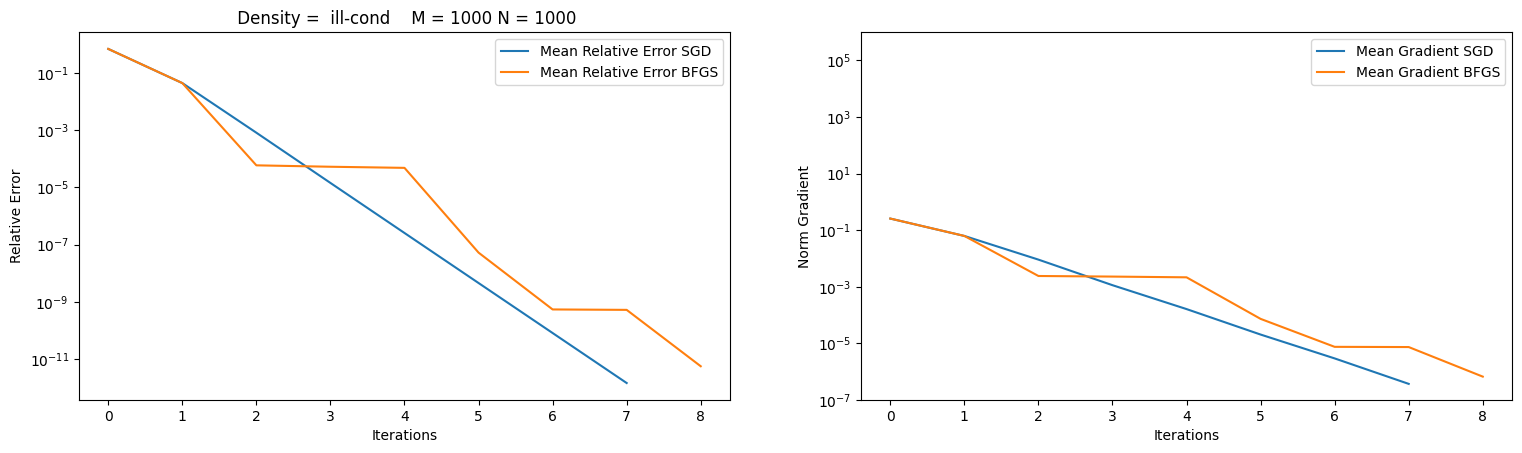

In [ ]:
printPlot(rel_errors_SGD, gradientsSGD, rel_errors_BFGS, gradientsBFGS, 'ill-cond')